In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.cluster import contingency_matrix

In [2]:
%%time
df = pd.read_csv("../data/df_CatVal_cleanedV3.csv",
               encoding="utf-8", low_memory=False, index_col=0)

CPU times: total: 39.9 s
Wall time: 40 s


In [3]:
df.shape

(1833614, 144)

In [4]:
df.dropna(subset=['product_name'], inplace=True)

In [5]:
df_init = df

In [7]:
df['pnns1'] = pd.factorize(df['pnns1'])[0]

### Normalisation

In [8]:
# Sélectionner les colonnes numériques
numeric_cols = list(df.select_dtypes(include=["float64","int64"]).columns)
numeric_cols.remove('pnns1')

In [9]:
# Créer un scaler StandardScaler
scaler = StandardScaler()

In [10]:
# Appliquer la normalisation aux colonnes numériques
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [11]:
# Sélectionner les colonnes numériques
cols_to_convert_int = list(df.select_dtypes(include=["int64"]).columns)
cols_to_convert_float = list(df.select_dtypes(include=["float64"]).columns)

# Changement du type des colonnes numériques pour réduire la mémoire
df[cols_to_convert_int] = df[cols_to_convert_int].astype('int32')
df[cols_to_convert_float] = df[cols_to_convert_float].astype('float32')

### X et y

In [12]:
# Supprimer quelques colonnes numériques non utiles à l'apprentissage
numeric_cols.remove('nutriscore')
numeric_cols.remove('unique_scans_n')
numeric_cols.remove('completeness')

In [13]:
X = df[numeric_cols]

In [14]:
y = df['product_name']

### Petite PCA

In [15]:
# Réduire la dimensionnalité avec PCA
pca = PCA(n_components=20)
pca_df = pd.DataFrame(pca.fit_transform(df[numeric_cols]))

In [16]:
from sklearn.cluster import KMeans

k = 20
k_values = range(1, k+1)
inertias = []
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pca_df)
    inertias.append(kmeans.inertia_)

C:\Users\joell\VSCode\OpenFoodFact_Cluster\env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\joell\VSCode\OpenFoodFact_Cluster\env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\joell\VSCode\OpenFoodFact_Cluster\env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\joell\VSCode\OpenFoodFact_Cluster\env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppre

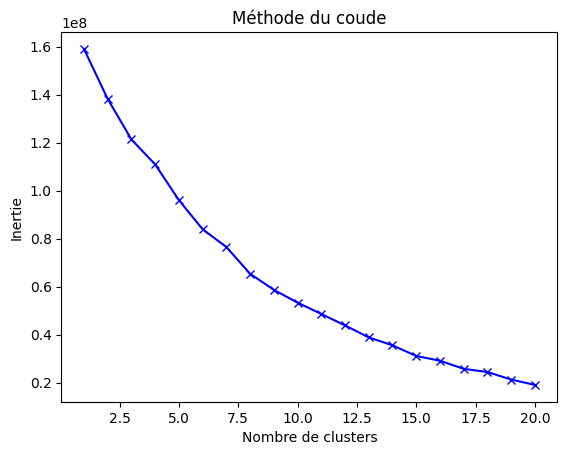

In [17]:
import matplotlib.pyplot as plt

plt.plot(k_values, inertias, 'bx-')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title("Méthode du coude")
plt.show()

In [18]:
# Sélectionner le nombre optimal de clusters
k = 11

## K-means avec PCA

In [19]:
# Appliquer K-means avec le nombre optimal de clusters (avec PCA)
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(pca_df)

C:\Users\joell\VSCode\OpenFoodFact_Cluster\env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=11, random_state=42)

In [20]:
df['cluster_K_pca'] = kmeans.labels_

C:\Users\joell\AppData\Local\Temp\ipykernel_14196\4222455833.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['cluster_K_pca'] = kmeans.labels_


In [21]:
kmeans.inertia_

48855300.0

In [22]:
adjusted_mutual_info_score(df['pnns1'],df['cluster_K_pca'])

0.9396360900122999

In [23]:
import joblib
# Enregistrer le modèle sur le disque
#joblib.dump(kmeans, 'kmeans_pca.pkl')
# Charger le modèle sauvegardé depuis le disque
#kmeans = joblib.load('kmeans_pca.pkl')

Nuage de mots

In [23]:
import nltk
import collections as co
from io import StringIO
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\joell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [24]:
# Définition des stop words
stop_words = set(stopwords.words('english'))
stop_words_fr = set(stopwords.words('french'))
stop_words_spanish = set(stopwords.words('spanish'))
stop_words_italian = set(stopwords.words('italian'))

stop_words |= stop_words_fr 
stop_words |= stop_words_spanish
stop_words |= stop_words_italian

stop_words.add('free')
stop_words.add('style')
stop_words.add('mini')
stop_words.add('bio')
stop_words.add('s')
stop_words.add('n')
stop_words.add('mit')

Cluster PCA

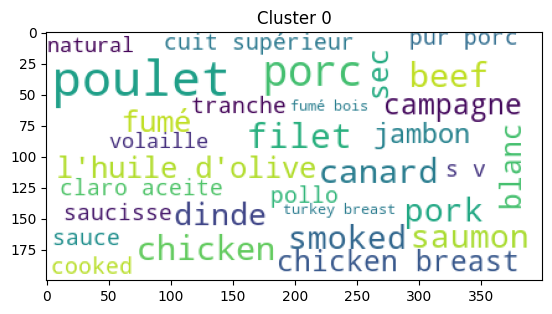

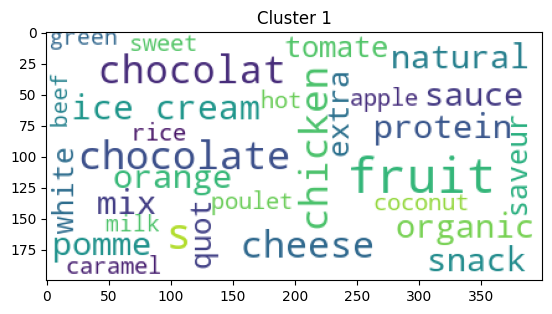

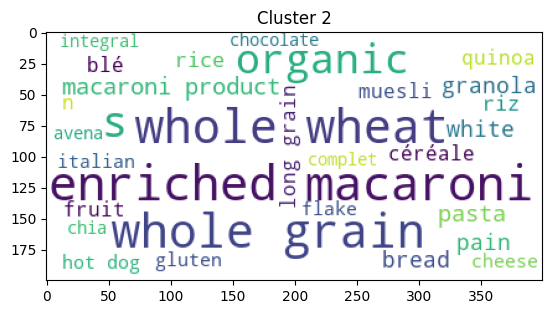

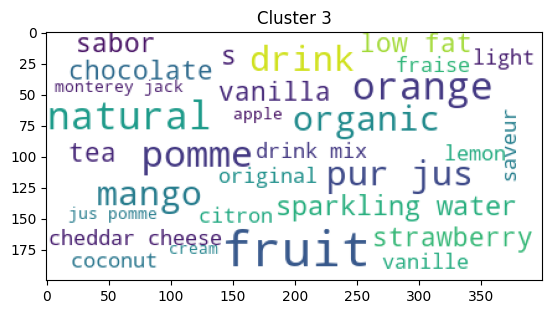

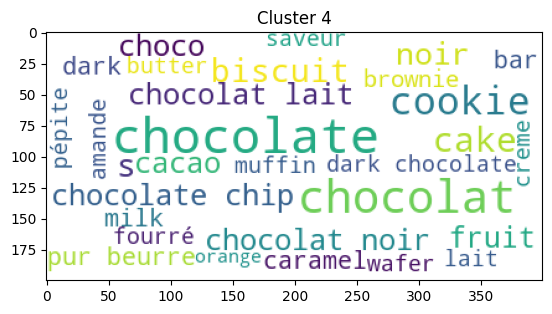

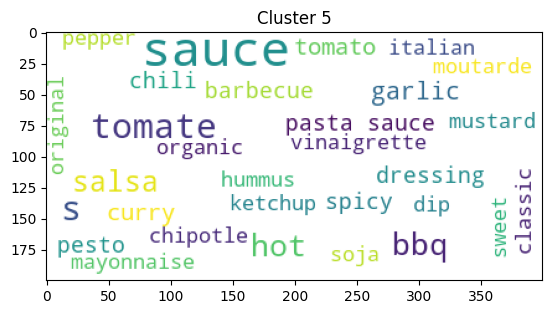

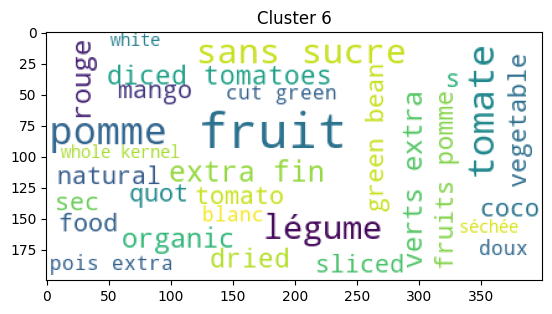

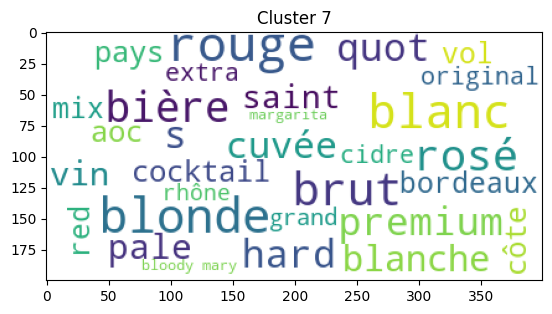

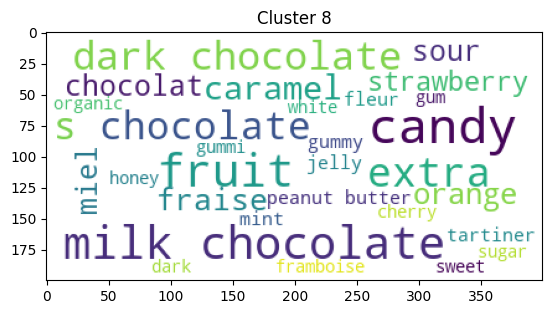

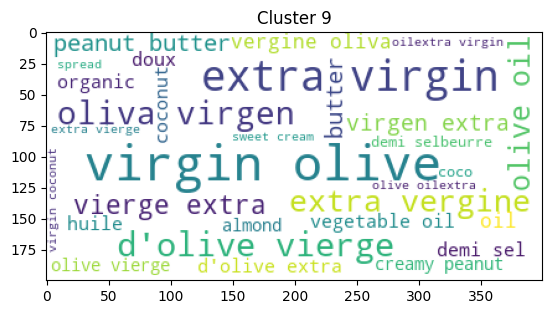

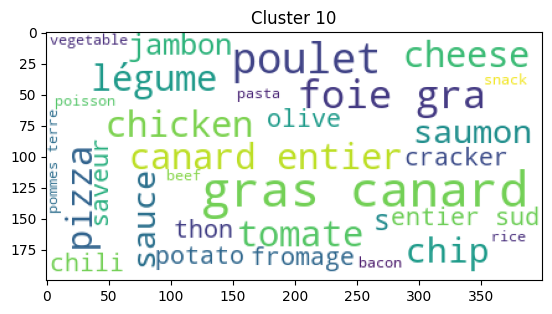

In [25]:
clusterPCA_0 = df['product_name'].where(df['cluster_K_pca'] == 0)
clusterPCA_1 = df['product_name'].where(df['cluster_K_pca'] == 1)
clusterPCA_2 = df['product_name'].where(df['cluster_K_pca'] == 2)
clusterPCA_3 = df['product_name'].where(df['cluster_K_pca'] == 3)
clusterPCA_4 = df['product_name'].where(df['cluster_K_pca'] == 4)
clusterPCA_5 = df['product_name'].where(df['cluster_K_pca'] == 5)
clusterPCA_6 = df['product_name'].where(df['cluster_K_pca'] == 6)
clusterPCA_7 = df['product_name'].where(df['cluster_K_pca'] == 7)
clusterPCA_8 = df['product_name'].where(df['cluster_K_pca'] == 8)
clusterPCA_9 = df['product_name'].where(df['cluster_K_pca'] == 9)
clusterPCA_10 = df['product_name'].where(df['cluster_K_pca'] == 10)


s_arr = []

def sio_factory():
    return StringIO()

for cluster in [clusterPCA_0, clusterPCA_1, clusterPCA_2, clusterPCA_3, clusterPCA_4,clusterPCA_5, clusterPCA_6,
                clusterPCA_7, clusterPCA_8, clusterPCA_9, clusterPCA_10]:

    si = sio_factory()
    cluster.apply(lambda x: si.write(str(x)))
    s_arr.append(si.getvalue())
    si.close()
    
cleaned = []
for s in s_arr:
    tokenized = word_tokenize(s)
    filtered_tokenized = list(filter(lambda x: x.lower() not in stop_words, tokenized))
    cleaned.append(filtered_tokenized)
    
final = []
for i in cleaned:
    final.append(' '.join(i))

for i, s in enumerate(final):
    text = s
    wordcloud = WordCloud(background_color="white",max_words=30,max_font_size=40, relative_scaling=.5).generate(text)
    plt.title('Cluster ' + str(i))
    plt.imshow(wordcloud)
    plt.show()

Categories dans chaque cluster

In [26]:
def print_top_10(df, col):
    res = df[col].head(10)
    for el in res:
        print(f'    - {el}')

In [27]:
prd_names = df['product_name'].loc[df.index]
cats_name = df['categories'].loc[df.index]
df['cats'] = cats_name
df['names'] = prd_names 

C:\Users\joell\AppData\Local\Temp\ipykernel_14196\2691426148.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['cats'] = cats_name
C:\Users\joell\AppData\Local\Temp\ipykernel_14196\2691426148.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['names'] = prd_names


In [28]:
for i in range(17):
    tmp_df = df[df['cluster_K_pca'] == i]
    tmp_df = tmp_df.sample(frac=1)
    print(f'Produit du cluster {i} :\n')
    print_top_10(tmp_df,'cats')
    print()

Produit du cluster 0 :

    - snack , meat and their product , salty snack , appetizer , meal , meat , puff pastry meal , veal meat , vol au vent , kalfsragout
    - meat and their product , meat , prepared meat
    - meat and their product , meat , prepared meat , sausage , french sausage , chipolata
    - seafood , fish , fatty fish , fish fillet , mackerel , mackerel fillet
    - meat and their product , meat , prepared meat
    - farming product , egg
    - meat and their product , meat , chicken and it product , poultry , chicken , chicken wing
    - seafood , canned food , fish , fatty fish , canned fish , sardine , canned sardine , sardine in oil , sardine in tomato sauce
    - seafood , canned food , fish , fatty fish , canned fish , sardine , canned sardine , sardine in oil , sardine in olive oil
    - meat and their product , meat , chicken and it product , poultry , chicken

Produit du cluster 1 :

    - bee product , royal jelly
    - unknown
    - unknown
    - unknown
   

Produit du cluster 10 :

    - canned food , meal , gratins , potato gratin , canned meal , tartiflettes , canned tartiflettes
    - meal , pasta dish , stuffed pasta , ravioles
    - meat and their product , spread , meat , prepared meat , salted spread , savory mousse , duck mousse
    - plant based food and beverage , plant based food , nut and their product , nut , cashew nut
    - snack , salty snack , appetizer , cracker
    - meal , prepared salad , salad
    - plant based food and beverage , plant based food , meal , dried product , dried product to be rehydrated , rice dish , dried meal , risotto , plant based meal , vegetable risotto , mushroom risotto
    - plant based food and beverage , plant based food , canned food , fruit and vegetable based food , canned plant based food , pickle , vegetable based food , canned vegetable , olive tree product , plant based pickle , olive
    - meal , prepared salad , lentil dish , lentil salad , salad
    - plant based food and beverage

In [29]:
cm = contingency_matrix(df['pnns1'],df['cluster_K_pca'])
cm

array([[      5, 1116040,       4,      48,       3,       4,      11,
             39,       9,       6,       6],
       [      0,       0,       0,       0,       0,   51572,       0,
              0,       0,   14330,       0],
       [      0,       0,       1,       5,       0,       0,       0,
              0,       0,       0,   56161],
       [      0,       0,       0,       0,       0,       0,   53620,
              0,       0,       1,       1],
       [      0,      15,       0,   67425,       0,       0,       4,
              1,       6,       1,       0],
       [  83721,       0,       1,       4,       0,       1,       3,
              0,       0,       0,       0],
       [      0,       0,   92130,       2,       0,       0,       3,
              7,       1,       2,    1875],
       [      0,       0,       0,       0,       0,       0,       0,
              1,       0,       0,   37090],
       [      0,       0,       1,       2,   86412,       0,       0,
 

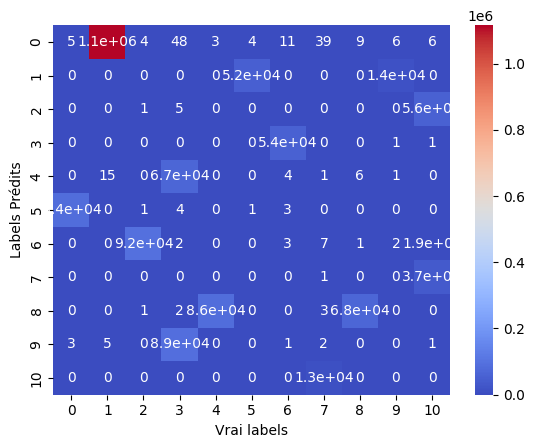

In [30]:
ax = sns.heatmap(cm, annot=True, cmap ='coolwarm');
ax.set_xlabel("Vrai labels");
ax.set_ylabel("Labels Prédits");

In [ ]:
sns.pairplot(df.drop(columns=['pnns1']), hue='cluster_K_pca', palette=sns.color_palette("tab10", 11))